In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy

from PIL import Image

### find images

In [2]:
!ls data/images

123946.png 124105.png 124205.png 124245.png


In [3]:
# old_img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
# old_img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in old_img_names}

# for img in old_img_paths:
#     if "Screenshot" in img:
#         new_name = img[-10:]
#         new_path = os.path.join(cwd, "data", "images", new_name)
#         old_path = old_img_paths[img]
#         os.rename(old_path, new_path)

img_names = [img_name for img_name in os.listdir(os.path.join("data", "images")) if "png" in img_name]
cwd = os.getcwd()
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', '124245.png', '124105.png', '124205.png'])

In [4]:
!ls /Users/jordansmith/Library/CloudStorage/OneDrive-Reply/CarbonIntensityProject/Carbon-Intensity-Project-/data/images

123946.png 124105.png 124205.png 124245.png


### import image

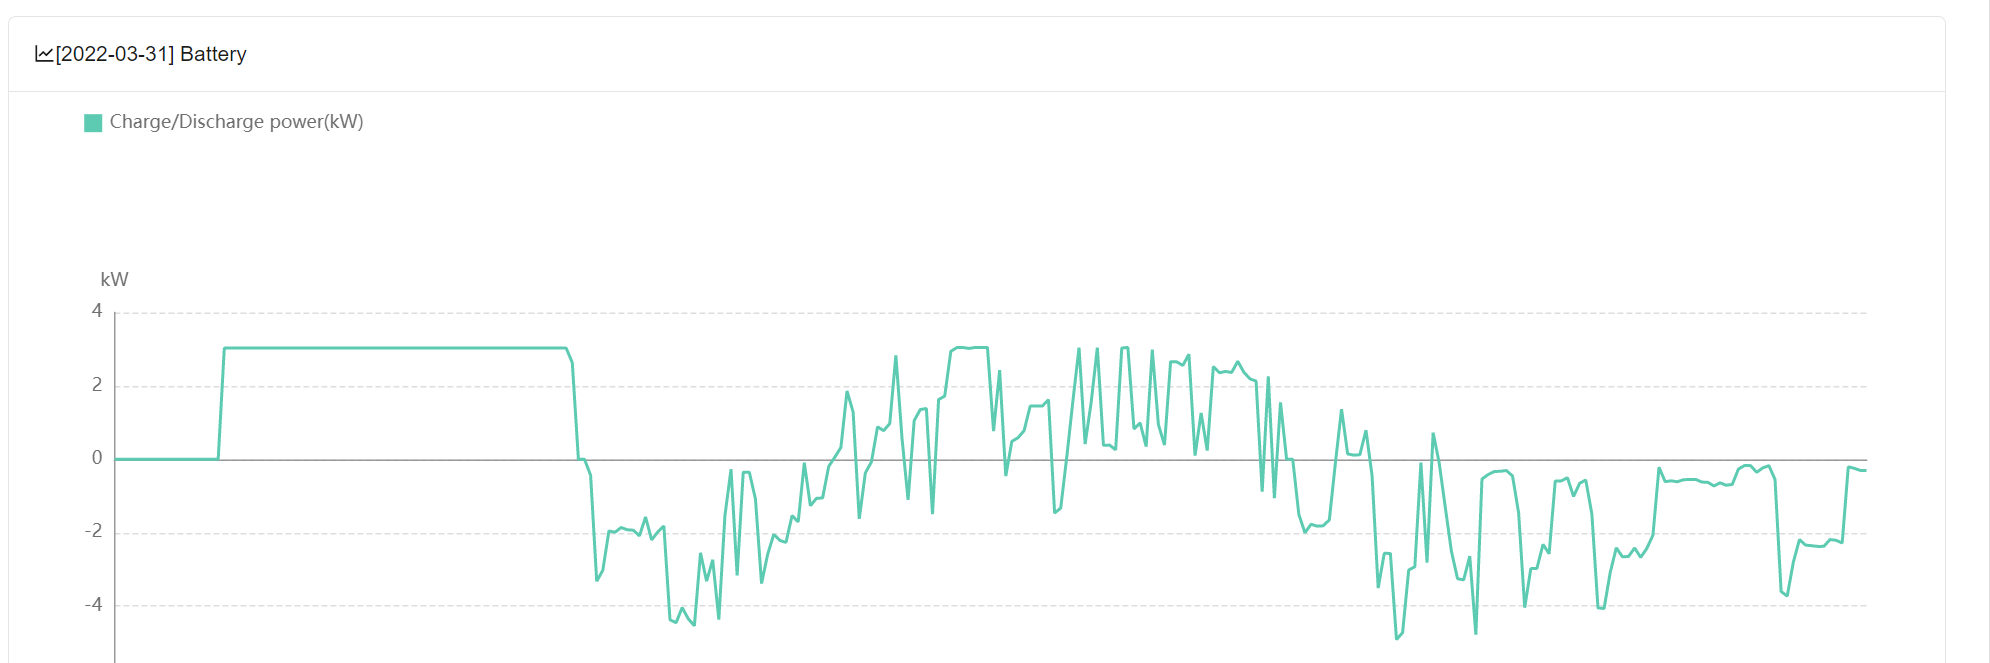

In [5]:
# exract the image
img = Image.open(img_paths[img_names[0]]).convert("RGB")
img_arr = np.asarray(img)

# generate dataframe and array of non-white pixel values 
non_white_values = np.argwhere(img_arr != 255)
list_pixel_values_subsection = []
for i in range(len(non_white_values)):
    vals_ = img_arr[non_white_values[i][0], non_white_values[i][1]]
    list_pixel_values_subsection.append(vals_)

col_names = ['r', 'g', 'b']
df = pd.DataFrame(list_pixel_values_subsection, columns=col_names)

# show the image
img

### plot colours and find rgb values of plot

(None, {'r': 92, 'g': 203, 'b': 177})

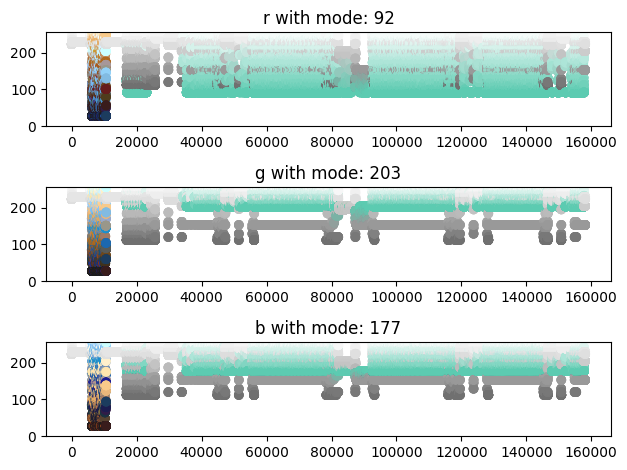

In [6]:
fig, axs = plt.subplots(3)
target_col_dict = {}
for i,col in enumerate(col_names):
    y = df[col]
    axs[i].scatter(np.arange(len(y)), y, label=col, c=np.array(df[col_names])/255)
    axs[i].set_title(f"{col} with mode: {y.mode().values[0]}")
    axs[i].set_ylim(0,255)
    target_col_dict[col] = y.mode().values[0]
    
fig.tight_layout(), target_col_dict

Now that we know the pixel colour values corresponding to the data in the plot, a function to find all these datapoints from the image is needed using the target_col_dict.

In [24]:
np.argwhere(img_arr[:,:,:-2] == np.array([val for val in target_col_dict.values()])).shape # TODO Continue here make this functino 

(16666, 3)

## find the grid axes lines

### convolve image with horizontal filter kernel

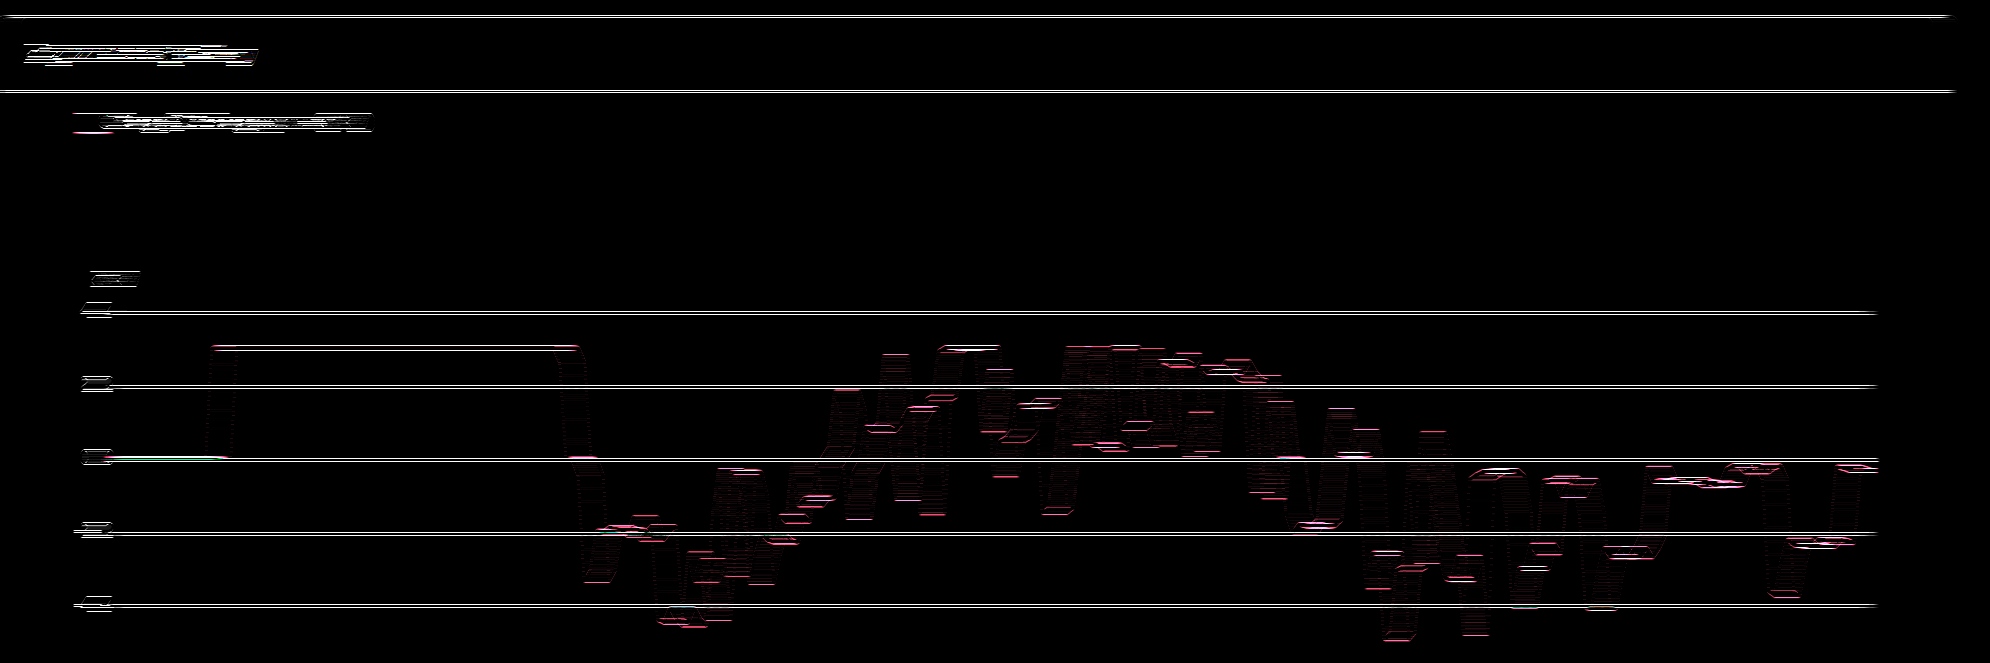

In [7]:
width = 25
convolution_kernel = np.array([[-1]*width, 
                               [2]*width, 
                               [-1]*width])

result_x = cv2.filter2D(img_arr, -1, convolution_kernel)
Image.fromarray(result_x)

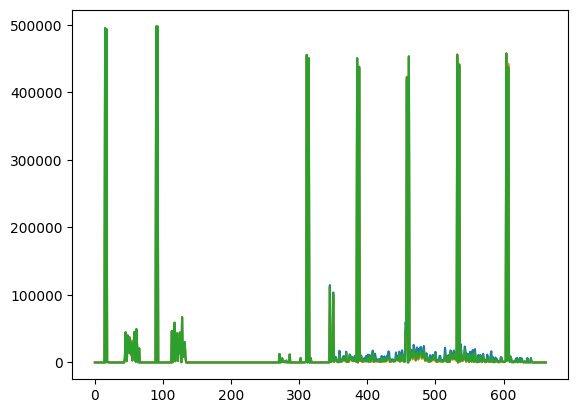

In [8]:
img_height = result_x.shape[0]
img_width = result_x.shape[1]

# calculate sum of response in horizontal direction
sum_arr_along_x = np.sum(result_x, axis=1)
plt.plot(sum_arr_along_x)

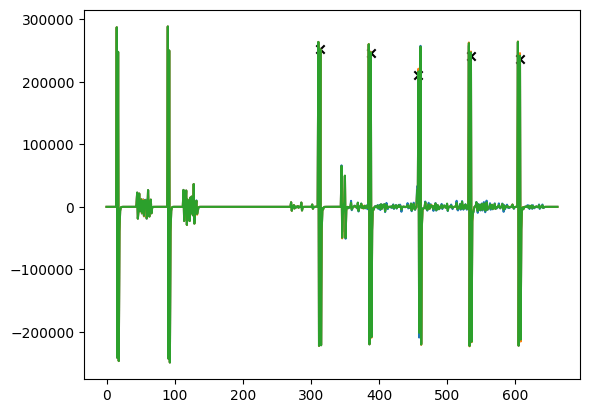

In [13]:
# remove the baseline wonder, uncomment above to see why
sos = scipy.signal.butter(1, 1, 'hp', fs=5, output='sos')
def hpf(a):
    return scipy.signal.sosfilt(sos, a)
filtered_sum_arr_along_x = np.apply_along_axis(hpf, 0, sum_arr_along_x)
plt.plot(filtered_sum_arr_along_x)

# detect peaks
r_arr = filtered_sum_arr_along_x[:,0] # only run calculations on r component of pixel values
peaks_x = scipy.signal.find_peaks(r_arr, height=0.7*max(r_arr))[0]
peaks_x = [peak for peak in peaks_x if peak >= 200] # remove the peaks not wanted on the left 

def remove_double_peaks(peaks_x, r_arr):
    peaks_y = r_arr[peaks_x]
    chosen_peaks = []
    for i,peak in enumerate(peaks_x):
        if i != len(peaks_x)-1:
            if abs(peaks_x[i+1] - peak) / peaks_x[-1] < 0.05:
                if peaks_y[i] <= peaks_y[i+1]:
                    chosen_peaks.append(peak)
                else:
                    chosen_peaks.append(peaks_x[i+1])
            elif abs(peaks_x[i-1] - peak) / peaks_x[-1] < 0.05:
                pass
            
            else:
                chosen_peaks.append(peak) # this is for the case where single peak detected amongst double peaks
            
            
    return(chosen_peaks)
                    

peaks_x = remove_double_peaks(peaks_x, r_arr)
peaks_y = r_arr[peaks_x]
plt.scatter(peaks_x, peaks_y, marker='x', c='black')

Picture this plot rotated 90 degrees clockwise, and then along the y axis of the image above. The peaks correspond to high sum of response along the x axis when the image was convolved with a horizontal filter. Therefore, peaks here correspond to rows along the original image with a lot of 'horizontalness' (highest values are just straight horizontal lines).

Clearly, the 5 peaks identified between 300- 600 correspond to the Y values on the plot of 4, 2, 0, -2, -4.

For an unkown reason, the slightly lower peak corresponds more closely to the exact point in the plots where the y axes grid lines are. This is perhaps because the borders of the exes grid lines are detected stronger than the middle of the lines, due to filter choices. This can be explained with a diagram on request (picture the kernel passing over a line a couple pixels thick)

In [16]:
# generate dictionary from these values
y_values_on_graph = [4,2,0,-2,-4] # !!!!!!!!!!!!!!!! CHECK THESE IN FUTURE
batter_charge_range = max(y_values_on_graph) - min(y_values_on_graph)
pixel_location_range = max(peaks_x) - min(peaks_x)
scaling_multiplier = batter_charge_range / pixel_location_range # kW per pixel
baseline_y_value = int(np.mean(np.array([max(peaks_x), min(peaks_x)]))) # !!!!!! this needs changing if max and min arent +- same number 

def calculate_pixel_location(y_val_kw, scaling_multiplier, baseline_y_value):
    y_shift = y_val_kw/ scaling_multiplier
    return int(baseline_y_value - y_shift)

y_coord_dict = {y_val: calculate_pixel_location(y_val, scaling_multiplier, baseline_y_value) for y_val in y_values_on_graph}
y_coord_dict

{4: 313, 2: 386, 0: 460, -2: 533, -4: 606}

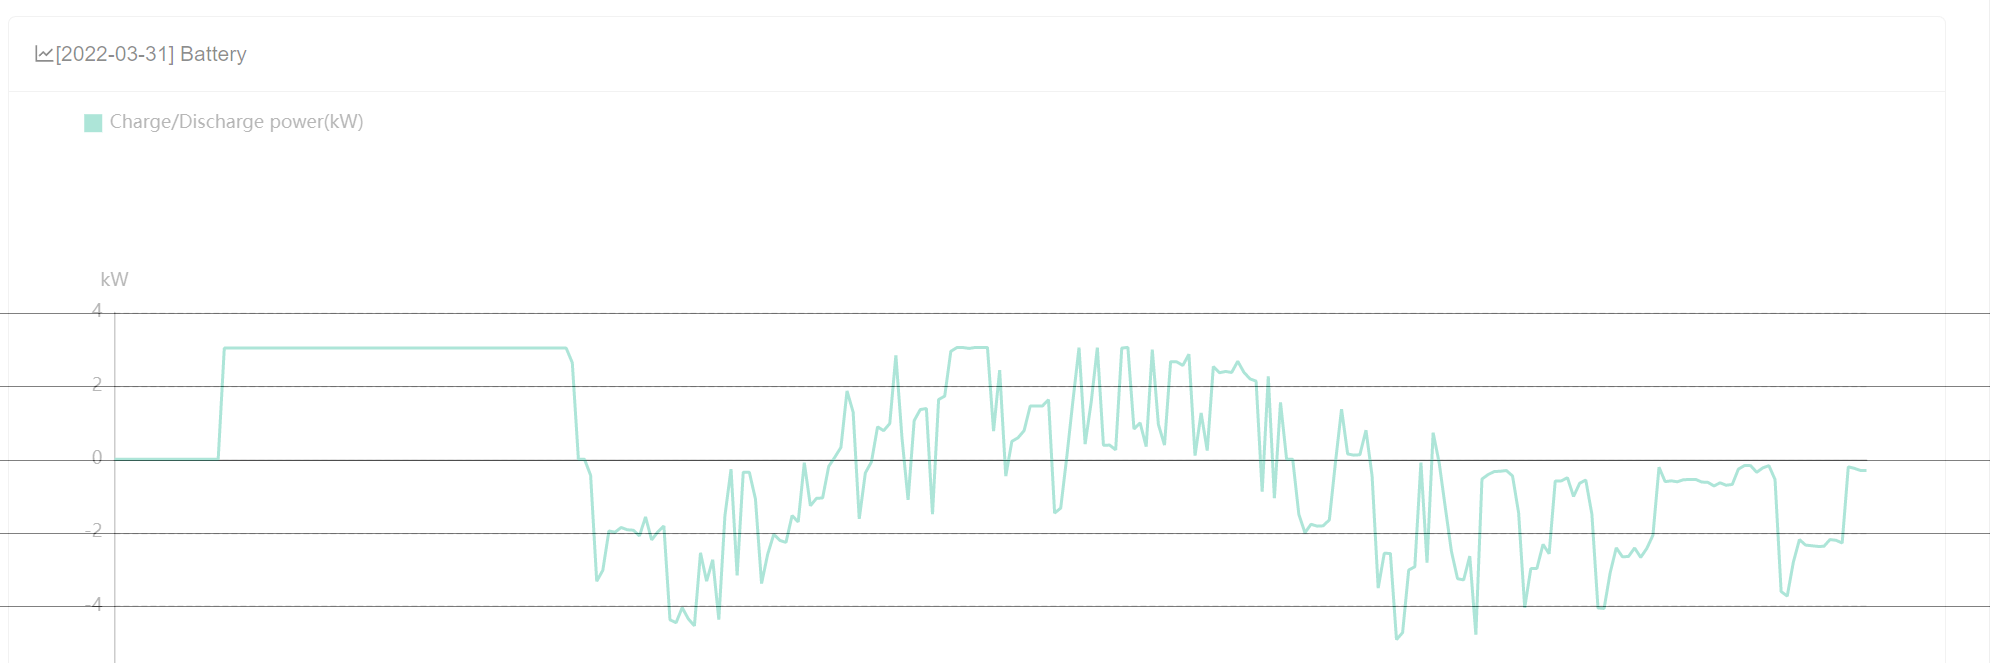

In [17]:
# check these values by plotting values calculated with this method on original image
black_line_pix_values = np.zeros((1,img_width,3), dtype="uint8")
white_image = np.ones(np.shape(img_arr),dtype="uint8")*255
for y_val in y_coord_dict:
    white_image[y_coord_dict[y_val]] =  black_line_pix_values
# white_images = np.concatenate((white_image, np.zeros((white_image.shape[0], white_image.shape[1],1))),axis=-1)
lines = Image.fromarray(white_image)
img_with_lines = img.copy()
lines.putalpha(127) # make partially transparent
img_with_lines.paste(lines, (0,0), lines)
img_with_lines

From the above image of the original plots, and original grid, with the prediced grid locations overlayed, we can see the predictions are accurate and these pixel values can be used for calculations in the y axis.

### find x pixel values for corresponding timescales